---

#Read Me
---

SETUP:
Ensure google drive has enough space (at least 12 GBs);
It is recommended to make a new account to have a fresh drive

Mount the Drive to the environment (using the icon in the colab explorer sidebar)

To install necessary resources, run the imports section, it will import automatically

For the first time running the program, run the first section  (Import the Dataset).  This section only needs to be run once, as it loads the images into the google drive for training.

Then, run

# Summary

Authors: Casey, D., Gallardo, N., Lindauer, S.R.

Project: Galaxy Zoo

This file starts by loading the pre-transformed dataset as numpy files. 

It splits the dataset into train and val for training. 

Then, it builds the model using standard CNN layers, including a normalization layer, a relu activation function for regression, and 37 outputs for the 37 morphologies. 

The model's fit function is then ran to train the model, and early stopping was implemented on the RMSE metric.

Finally, the model is evaluated on both RMSE and accuracy.

# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from pandas.plotting import scatter_matrix
import tensorflow as tf
import PIL

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Load the Dataset

In [ ]:
# This should match what was used in get_data.ipynb
data_size = 10000

# Change directory to the data directory to be where the data files are
%cd /content/drive/MyDrive/Colab Notebooks/data/

# Load in the npy data
images = np.load('images_training_{}.npy'.format(data_size))
labels = np.load('labels_training_{}.npy'.format(data_size))


/content/drive/MyDrive/Colab Notebooks/data


# Train/Val Split

In [ ]:
# Train/val split
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=1)

In [ ]:
x_train = np.asarray(x_train, dtype=np.float32)

In [ ]:
x_train.shape

(8000, 69, 69, 3)

In [ ]:
x_test = np.asarray(x_val, dtype=np.float32)

In [ ]:
x_test.shape

(2000, 69, 69, 3)

In [ ]:
y_train.shape

(8000, 37)

In [ ]:
y_val.shape

(2000, 37)

# Build the Model

In [ ]:
# Define the layers of a convolutional neural network
num_labels = 37

model = Sequential([
  layers.Rescaling(1./255, input_shape=(69, 69, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_labels)
])

In [ ]:
# Choose an optimizer and loss for multi label regression
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.001),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError(), 'accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
# See model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 69, 69, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 69, 69, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 34, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 17, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 64)        1

## Train the model

In [ ]:
# Set large epoch number and early stopping
epochs = 100
callback = tf.keras.callbacks.EarlyStopping(monitor='root_mean_squared_error', patience=5)

# Fit the regression model
history = model.fit(x_train, y_train,
   epochs=epochs, batch_size=32, validation_data=(x_test, y_val), callbacks=[callback])

Epoch 1/100
250/250 [==============================] - 37s 147ms/step - loss: 0.0611 - root_mean_squared_error: 0.2471 - accuracy: 0.5639 - val_loss: 0.0583 - val_root_mean_squared_error: 0.2416 - val_accuracy: 0.5955
Epoch 2/100
250/250 [==============================] - 37s 147ms/step - loss: 0.0576 - root_mean_squared_error: 0.2400 - accuracy: 0.5936 - val_loss: 0.0550 - val_root_mean_squared_error: 0.2346 - val_accuracy: 0.6075
Epoch 3/100
250/250 [==============================] - 37s 148ms/step - loss: 0.0544 - root_mean_squared_error: 0.2332 - accuracy: 0.5995 - val_loss: 0.0519 - val_root_mean_squared_error: 0.2279 - val_accuracy: 0.6095
Epoch 4/100
250/250 [==============================] - 36s 146ms/step - loss: 0.0513 - root_mean_squared_error: 0.2265 - accuracy: 0.6014 - val_loss: 0.0489 - val_root_mean_squared_error: 0.2212 - val_accuracy: 0.6105
Epoch 5/100
250/250 [==============================] - 36s 142ms/step - loss: 0.0483 - root_mean_squared_error: 0.2198 - accurac

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/model_snapshots/{}_epochs_{}_data'.format(epochs, data_size))

# Eval

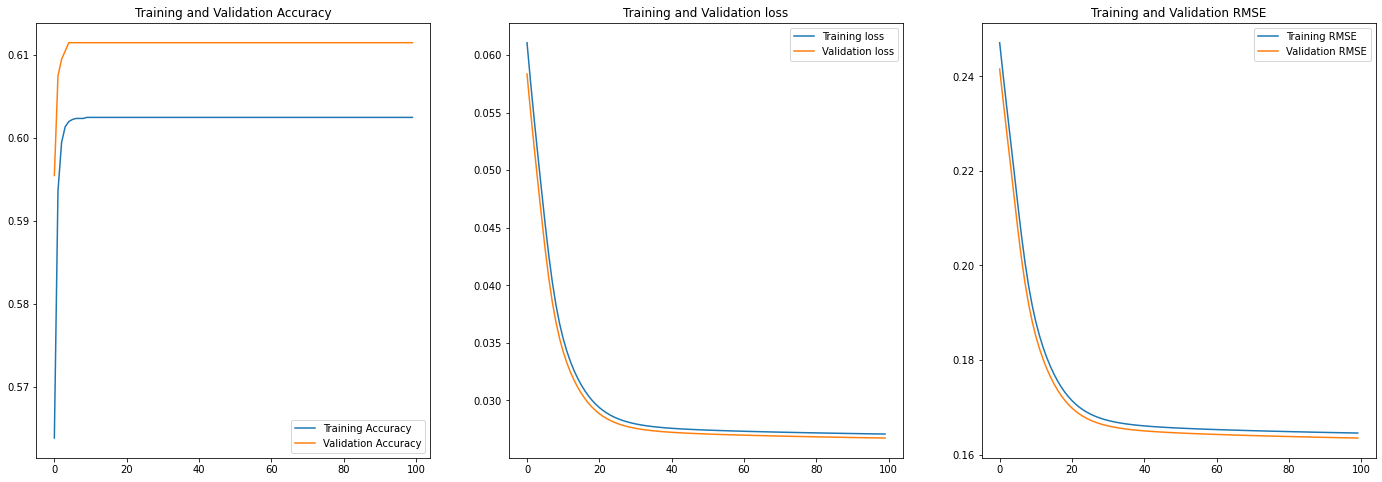

In [ ]:
#Evaluation
#Approach based off of https://www.tensorflow.org/tutorials/images/classification
accuracy = history.history['accuracy']
validation_acc = history.history['val_accuracy']

loss = history.history['loss'] #Is this loss?
validation_loss = history.history['val_loss']

RMSE_acc = history.history['root_mean_squared_error']
RMSE_val_acc = history.history['val_root_mean_squared_error']

epochs_range = range(epochs)

plt.figure(figsize=(24,8))

plt.subplot(1,3,1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,3,2)
plt.plot(epochs_range, loss, label = 'Training loss')
plt.plot(epochs_range, validation_loss, label = 'Validation loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation loss')

plt.subplot(1,3,3)
plt.plot(epochs_range, RMSE_acc, label = 'Training RMSE')
plt.plot(epochs_range, RMSE_val_acc, label = 'Validation RMSE')
plt.legend(loc='upper right')
plt.title('Training and Validation RMSE')
plt.show()